# A2 - Manual Hyperparameter search report

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import random_split
import matplotlib.pyplot as plt

Import and Preprocess the data

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size

train_data, val_data = random_split(train_set, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128,
                                          shuffle=False, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=128,
                                         shuffle=False, num_workers=2)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=128,
                                         shuffle=False, num_workers=2)




Files already downloaded and verified
Files already downloaded and verified


In [3]:
device=torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

### Model training

Before training:

- Loss function: to measure how good the network is. We choose Cross entropy loss
- Optimizer: to update network as it sees more data and reduce loss value. We use SGD optimizer.

- Metrics: to monitor performance of network. We evaluate the model by using accuracy.

Functions for train and evaluate

In [4]:
def train(model, train_loader, criterion, optimizer, device, epochs=10):
  model.train()
  for epoch in range(epochs):
      for images, labels in train_loader:
          images, labels = images.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()


def evaluate(model, val_loader, criterion, device):
  model.eval()
  correct = 0
  total = 0
  val_loss = 0.0
  with torch.no_grad():
      for images, labels in val_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, labels)
          val_loss += loss.item()
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  return val_loss / len(val_loader), accuracy

## Learning rate

Function to create graphs showing the effect of different learning rates on the model's validation loss and accuracy.


In [5]:
def lr_plot(learning_rates, val_losses, accuracies):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(learning_rates, val_losses, marker='o', label='Validation Loss')
  plt.xscale('log')
  plt.xlabel('Learning Rate')
  plt.ylabel('Validation Loss')
  plt.title('Impact du Learning Rate sur la Loss')
  plt.grid()
  plt.legend()


  plt.subplot(1, 2, 2)
  plt.plot(learning_rates, accuracies, marker='o', label='Accuracy')
  plt.xscale('log')
  plt.xlabel('Learning Rate')
  plt.ylabel('Accuracy (%)')
  plt.title('Impact du Learning Rate sur l’Accuracy')
  plt.grid()
  plt.legend()

  plt.tight_layout()
  plt.show()

Training and evaluation of multiple learning rates on the model's performance by measuring validation loss and accuracy.


Learning rate: 0.1, Validation Loss: 2.0457, Accuracy: 41.01%
Learning rate: 0.01, Validation Loss: 2.0273, Accuracy: 42.76%
Learning rate: 0.001, Validation Loss: 2.0256, Accuracy: 42.99%
Learning rate: 0.0001, Validation Loss: 2.0254, Accuracy: 43.02%


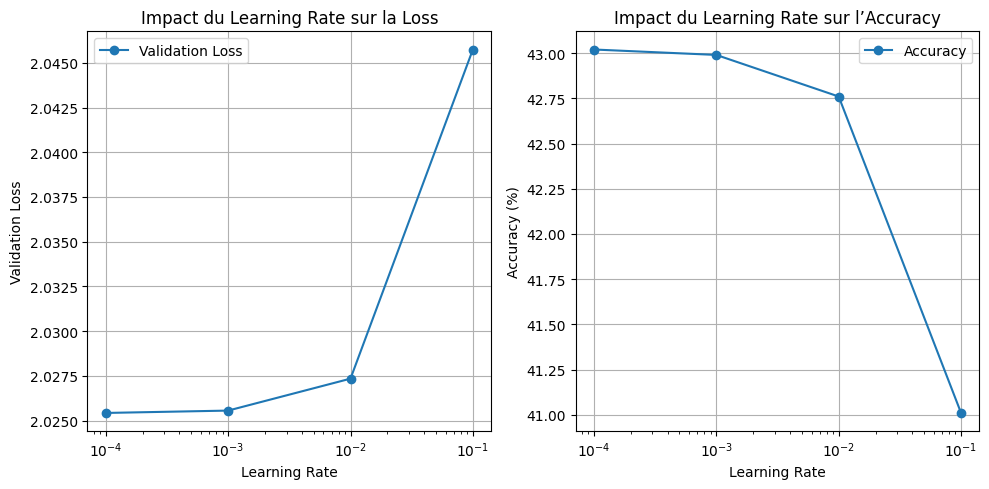

In [7]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]
results = []
val_losses = []
accuracies = []
model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(32 * 32 * 3, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 10),
        nn.Softmax(dim=1)
    )
for lr in learning_rates:
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train(model, train_loader, criterion, optimizer, device)
    val_loss, accuracy = evaluate(model, val_loader, criterion, device)
    results.append((lr, val_loss, accuracy))


for lr, val_loss, acc in results:
    print(f"Learning rate: {lr}, Validation Loss: {val_loss:.4f}, Accuracy: {acc:.2f}%")
    val_losses.append(val_loss)
    accuracies.append(acc)

lr_plot(learning_rates, val_losses, accuracies)


## Activation Function

Function to plot the performance of different activation functions by visualizing their accuracies.


In [8]:
def af_plot(activations, accuracies):
  plt.bar(activations, accuracies, color='skyblue')
  plt.xlabel('Activation Function')
  plt.ylabel('Accuracy (%)')
  plt.title('Performance des Fonctions d’Activation')
  plt.grid(axis='y')
  plt.show()

Training and evaluation of multiple activation functions on the model's performance by measuring accuracy on the validation set.


Activation: ReLU, Accuracy: 9.89%
Activation: GeLu, Accuracy: 10.63%
Activation: Tanh, Accuracy: 14.88%
Activation: Sigmoid, Accuracy: 9.94%
Activation: LeakyReLU, Accuracy: 10.63%


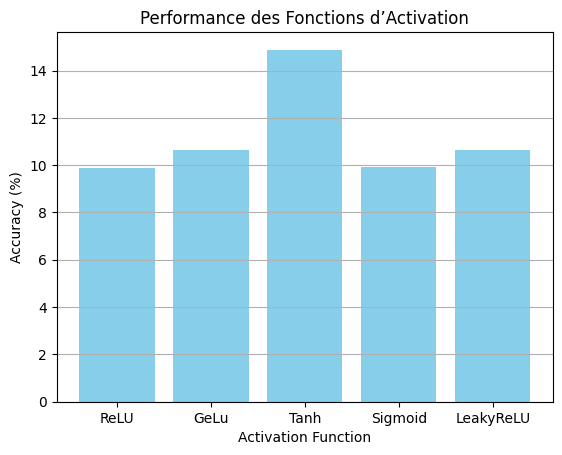

In [9]:
activations = {
    'ReLU': nn.ReLU(),
    'GeLu': nn.GELU(),
    'Tanh': nn.Tanh(),
    'Sigmoid': nn.Sigmoid(),
    'LeakyReLU': nn.LeakyReLU()
}

results = []
val_losses = []
accuracies = []
activation_names=[]
for name, activation in activations.items():
  model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(32 * 32 * 3, 64),
      activation,
      nn.Linear(64, 64),
      activation,
      nn.Linear(64, 64),
      activation,
      nn.Linear(64, 10),
      nn.Softmax(dim=1)
  ).to(device)

  optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()

  train(model, train_loader, criterion, optimizer, device, 5)
  val_loss, accuracy = evaluate(model, val_loader, criterion, device)
  results.append((name, accuracy))

for name, acc in results:
  print(f"Activation: {name}, Accuracy: {acc:.2f}%")
  accuracies.append(acc)
  activation_names.append(name)

af_plot(activation_names, accuracies)


## Number of hidden units

Function to plot the model's performance based on the number of hidden units, showing accuracy for different hidden layer sizes.


In [10]:
def hu_plot(hidden_units, accuracies):
  plt.plot(hidden_units, accuracies, marker='o', color='orange')
  plt.xlabel('Hidden Units')
  plt.ylabel('Accuracy (%)')
  plt.title('Performance en fonction du Nombre de Neurones Cachés')
  plt.grid()
  plt.show()

Training and evaluation of the model with different hidden layer sizes, measuring accuracy on the validation set for each configuration.


Hidden size: 32, Accuracy: 44.02%
Hidden size: 64, Accuracy: 45.42%
Hidden size: 128, Accuracy: 45.62%
Hidden size: 256, Accuracy: 43.85%


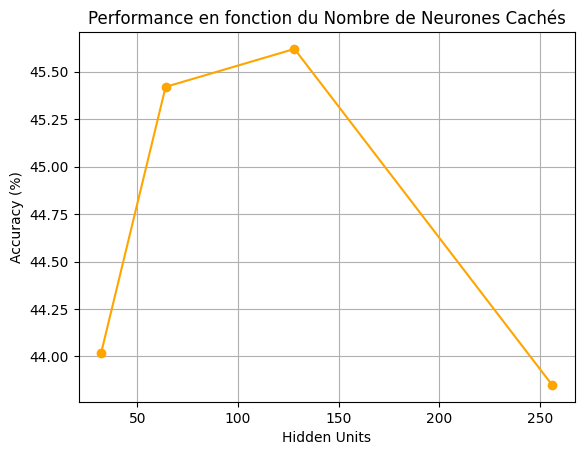

In [11]:
hidden_sizes = [32, 64, 128, 256]
results = []
accuracies = []
for size in hidden_sizes:
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(32 * 32 * 3, size),
        nn.ReLU(),
        nn.Linear(size, size),
        nn.ReLU(),
        nn.Linear(size, 10),
        nn.Softmax(dim=1)
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train(model, train_loader, criterion, optimizer, device, 5)
    val_loss, accuracy = evaluate(model, val_loader, criterion, device)
    results.append((size, accuracy))

for size, acc in results:
    print(f"Hidden size: {size}, Accuracy: {acc:.2f}%")
    accuracies.append(acc)
hu_plot(hidden_sizes, accuracies)


